# Flow charts, gas particle categorization

The code in this notebook was intended to explore how to categorize gas particles and how to represent the flow of gas particles between different states/categorizations. I'm saving this notebook in order to have a record of the code I used to make Sankey diagrams, in case I want to come back to this in the future.

This code has not been updated since January 2021. 

`-- Hollis Akins, May 18 2021 --`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

age = 13.800797497330507

In [3]:
key = 'h148_13'
path = '../../Data/tracked_particles.hdf5'
data = pd.read_hdf(path, key=key)
data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_Zc,host_vx,host_vy,host_vz,sat_disk,sat_halo,IGM,host_halo,host_disk,classification
0,6.474131,2202002,0.000050,619653.812500,27934.820603,1.502397,315.430011,7.446391,301.379304,38.695749,...,13319.769444,1.94,3.47,-22.95,False,False,True,False,False,5.0
1,6.474131,2205223,0.000034,246611.796875,26567.141174,0.000000,345.770111,8.162633,283.107089,38.728024,...,13319.769444,1.94,3.47,-22.95,False,False,True,False,False,5.0
2,6.474131,2857672,0.000074,708055.187500,26511.576364,0.000000,373.134629,8.808630,360.627617,-35.282347,...,13319.769444,1.94,3.47,-22.95,False,False,False,True,False,4.0
3,6.474131,4057198,0.000023,405099.468750,26510.536704,0.000000,593.153339,14.002636,563.303480,-183.727503,...,13319.769444,1.94,3.47,-22.95,False,False,True,False,False,5.0
4,6.474131,4073949,0.000024,405991.656250,26510.536704,0.000000,588.527236,13.893427,556.331718,-188.298945,...,13319.769444,1.94,3.47,-22.95,False,False,True,False,False,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447,13.800797,19009255,0.478361,733.537537,30288.071656,13.796250,284.462060,4.318511,49.714790,250.171752,...,24586.813120,3.62,11.77,-13.61,False,False,False,False,True,3.0
12448,13.800797,19078060,0.000206,840771.562500,26645.618222,8.779381,390.337777,5.925844,67.699234,345.184330,...,24586.813120,3.62,11.77,-13.61,False,False,False,True,False,4.0
12449,13.800797,19100998,0.000036,204305.203125,26859.950488,8.804634,85.520235,1.298310,-53.786871,36.639670,...,24586.813120,3.62,11.77,-13.61,False,False,False,True,False,4.0
12450,13.800797,19103645,0.000005,238948.421875,28078.179678,11.644720,154.169322,2.340494,129.548087,-47.754756,...,24586.813120,3.62,11.77,-13.61,False,False,False,True,False,4.0


In [4]:
data.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'x_rel_host',
       'y_rel_host', 'z_rel_host', 'h1dist', 'h1Rvir', 'sat_Xc', 'sat_Yc',
       'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc', 'host_Yc', 'host_Zc',
       'host_vx', 'host_vy', 'host_vz', 'sat_disk', 'sat_halo', 'IGM',
       'host_halo', 'host_disk', 'classification'],
      dtype='object')

We need to define the different categories we want to use

Or, not so much the different categories (those are already defined here) but rather we want to compile subsets of the overall dataset for gas particles identifies as heated out of the disk, ejected out of the disk, and expelled from the halo


One way to do this would be to start by identifying every **change of state**, and putting those into a new DataFrame. Columns would be the PID, the mass, the start state, the final state, the times, etc. From there, we could pick out state changes we're interested in ("disk"->"halo"), ("disk/halo"->"unbound"), ("halo"->"CGM") but we could also find particles that appear multiple times and see what the ordering of the changes are (i.e. "disk"->"not disk" and then "not disk"->"unbound")


Categories (unchanged): 
- sat disk
- sat halo
- host halo
- host disk
- IGM

Events: 
- heating from disk (thermo disk -> not thermo disk)
- ejecting from disk (spatial disk -> in satellite, not spatial disk)
- expelling from halo (inside Rvir -> outside Rvir)
- reaccreting to disk (anywhere -> thermo disk)

Could define categories to correspond to the events, which would make the whole process easier. The challenge is that "gas thats in the host halo" is not the same as "gas that was expelled from the satellite into the host halo"

Events need to be "changes of state" and this is what will go into the flow chart. 

# Stage 1: Start with thermodynamic disk gas, where does it go?

In [5]:
thermo_disk = (np.array(data.temp) < 1.2e4) & (np.array(data.rho) > 0.1)
spatial_disk = np.array(data.r_per_Rvir) < 0.15 # eventually the "spatial disk" should be defined as more of the "dynamical disk"
in_satellite = np.array(data.r_per_Rvir) < 1

cool_disk = thermo_disk & spatial_disk
hot_disk = ~thermo_disk & spatial_disk
cool_halo = thermo_disk & ~spatial_disk & in_satellite
hot_halo = ~thermo_disk & ~spatial_disk & in_satellite
CGM = ~in_satellite

In [6]:
c = cool_disk + 2*hot_disk + 3*cool_halo + 4*hot_halo + 5*CGM

In [7]:
classification = []

for i in range(len(c)):
    if c[i] == 1:
        classification.append('Cool Disk')
    elif c[i] == 2:
        classification.append('Hot Disk')
    elif c[i] == 3:
        classification.append('Cool Halo')
    elif c[i] == 4:
        classification.append('Hot Halo')
    elif c[i] == 5:
        classification.append('CGM')
        
classification = np.array(classification,dtype=str)
data['classification'] = classification

In [8]:
# loop through every particle
import tqdm
pids = np.unique(data.pid)
transfers1 = pd.DataFrame(columns = ['t1','t2','event','state1','state2','mass'])

for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    times = np.array(dat.time)
    mass = np.array(dat.mass)
    classification = np.array(dat.classification)
    
    for i,t2 in enumerate(times[1:]):
        i += 1
        t1 = times[i-1]
        c1 = classification[i-1]
        c2 = classification[i]
        
        if not c1 == 'Cool Disk':
            continue
            
        outdict = {'pid': [pid], 't1':[t1], 't2':[t2], 'state1':[c1], 'state2':[c2], 'mass':[mass[i]]}
        transfers1 = pd.concat([transfers1, pd.DataFrame(outdict)])

100%|██████████| 14729/14729 [01:14<00:00, 196.61it/s]


In [9]:
transfers1.head()

,t1,t2,event,state1,state2,mass,pid
0,10.783935,11.214915,NaN,Cool Disk,Hot Disk,28366.376150,2202002.0
0,12.076876,12.150951,NaN,Cool Disk,Cool Disk,28866.172758,2202002.0
0,12.150951,12.507856,NaN,Cool Disk,Hot Disk,29001.936444,2202002.0
0,9.060013,9.490994,NaN,Cool Disk,Cool Disk,26872.972141,2857672.0
0,9.490994,9.921974,NaN,Cool Disk,Hot Halo,27134.726367,2857672.0


Now we need to compute transfer *rates* from this dataframe. We do this using the handy `groupby` function in `pandas`, which will group the particle dataset by common times and transfer states and sum the mass transfer rate for that transfer at that time.

In [10]:
rates1 = transfers1.groupby(['state1','state2'])['mass'].sum()
rates1 = pd.DataFrame(rates1).reset_index()
rates1

,state1,state2,mass
0,Cool Disk,CGM,7.583869e+06
1,Cool Disk,Cool Disk,2.015059e+08
2,Cool Disk,Hot Disk,1.845660e+08
3,Cool Disk,Hot Halo,6.303500e+07


# Stage 2: Where does gas heated out of the disk go afterwards?

We need to use the data in the `transfers1` dataframe to identify gas particle IDs (PIDs) that experienced heating, and the time at which they did. 

In [173]:
transfers2 = pd.DataFrame(columns = ['t1','t2','state1','state2','mass'])
pids = np.unique(data.pid)

for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    times = np.array(dat.time)
    mass = np.array(dat.mass)

    classification = np.array(dat.classification)
    
    for i,t2 in enumerate(times[1:]):
        i += 1
        t1 = times[i-1]
        c1 = classification[i-1]
        c2 = classification[i]
        
        if (c1 == 'Hot Disk') and (classification[i-2] == 'Cool Disk'):
            outdict = {'pid': [pid], 't1':[t1], 't2':[t2], 'state1':[c1], 'state2':[c2], 'mass':[mass[i]]}
            transfers2 = pd.concat([transfers2, pd.DataFrame(outdict)])
        else: continue

100%|██████████| 14729/14729 [00:31<00:00, 466.32it/s]


In [174]:
transfers2.head()

,t1,t2,state1,state2,mass,pid
0,11.214915,11.645896,Hot Disk,Hot Disk,28366.657652,2202002.0
0,12.507856,12.938837,Hot Disk,Hot Halo,29001.936444,2202002.0
0,10.767100,10.783935,Hot Disk,Cool Disk,26839.452610,4073949.0
0,9.060013,9.490994,Hot Disk,CGM,27199.033300,4184960.0
0,10.767100,10.783935,Hot Disk,Cool Disk,27086.295834,4340176.0


In [175]:
rates2 = transfers2.groupby(['state1','state2'])['mass'].sum()
rates2 = pd.DataFrame(rates2).reset_index()
rates2

,state1,state2,mass
0,Hot Disk,CGM,6.464408e+06
1,Hot Disk,Cool Disk,6.347416e+07
2,Hot Disk,Hot Disk,8.020560e+07
3,Hot Disk,Hot Halo,3.329268e+07


In [176]:
np.sum(rates2.mass)

183436847.52763978

In [196]:
flows1 = [np.sum(rates1.mass), rates2.mass.tolist()[1], -rates1.mass.tolist()[1], -rates1.mass.tolist()[2], -rates1.mass.tolist()[3], -rates1.mass.tolist()[0]]
labels1 = ['Cool Disk', 'Reaccretion', 'Cool Disk', 'Hot Disk', 'Hot Halo', 'CGM']
orientations1 = [0, -1, 0, -1, -1, -1]

flows2 = [np.sum(rates2.mass), -rates2.mass.tolist()[1], -rates2.mass.tolist()[2], -rates2.mass.tolist()[3], -rates2.mass.tolist()[0]]
labels2 = ['', 'Reaccretion', 'Hot Disk', 'Hot Halo', 'CGM']
orientations2 = [-1, -1, 0, 1, 1]

print(flows1[3]/flows2[0])

-1.0061557668587036


[namespace(patch=<matplotlib.patches.PathPatch at 0x7ff5d1def748>,
           flows=array([ 4.56690785e+08,  6.34741560e+07, -2.01505879e+08, -1.84566042e+08,
                        -6.30349956e+07, -7.58386909e+06]),
           angles=[0, 1, 0, 3, 3, 3],
           tips=array([[-0.37186962,  0.03173708],
                       [-0.53173708, -0.4834519 ],
                       [ 1.36489965,  0.12759245],
                       [ 1.16290189, -0.58095303],
                       [ 0.78910137, -0.5299647 ],
                       [ 0.50379193, -0.50670019]]),
           text=Text(0, 0, ''),
           texts=[Text(-0.47186962126710996, 0.03173707801718459, 'Cool Disk'),
                  Text(-0.5317370780171846, -0.5834519002245439, 'Reaccretion'),
                  Text(1.4648996498226379, 0.1275924533216164, 'Cool Disk'),
                  Text(1.162901885646075, -0.680953030484182, 'Hot Disk'),
                  Text(0.789101366868501, -0.6299647023647199, 'Hot Halo'),
              

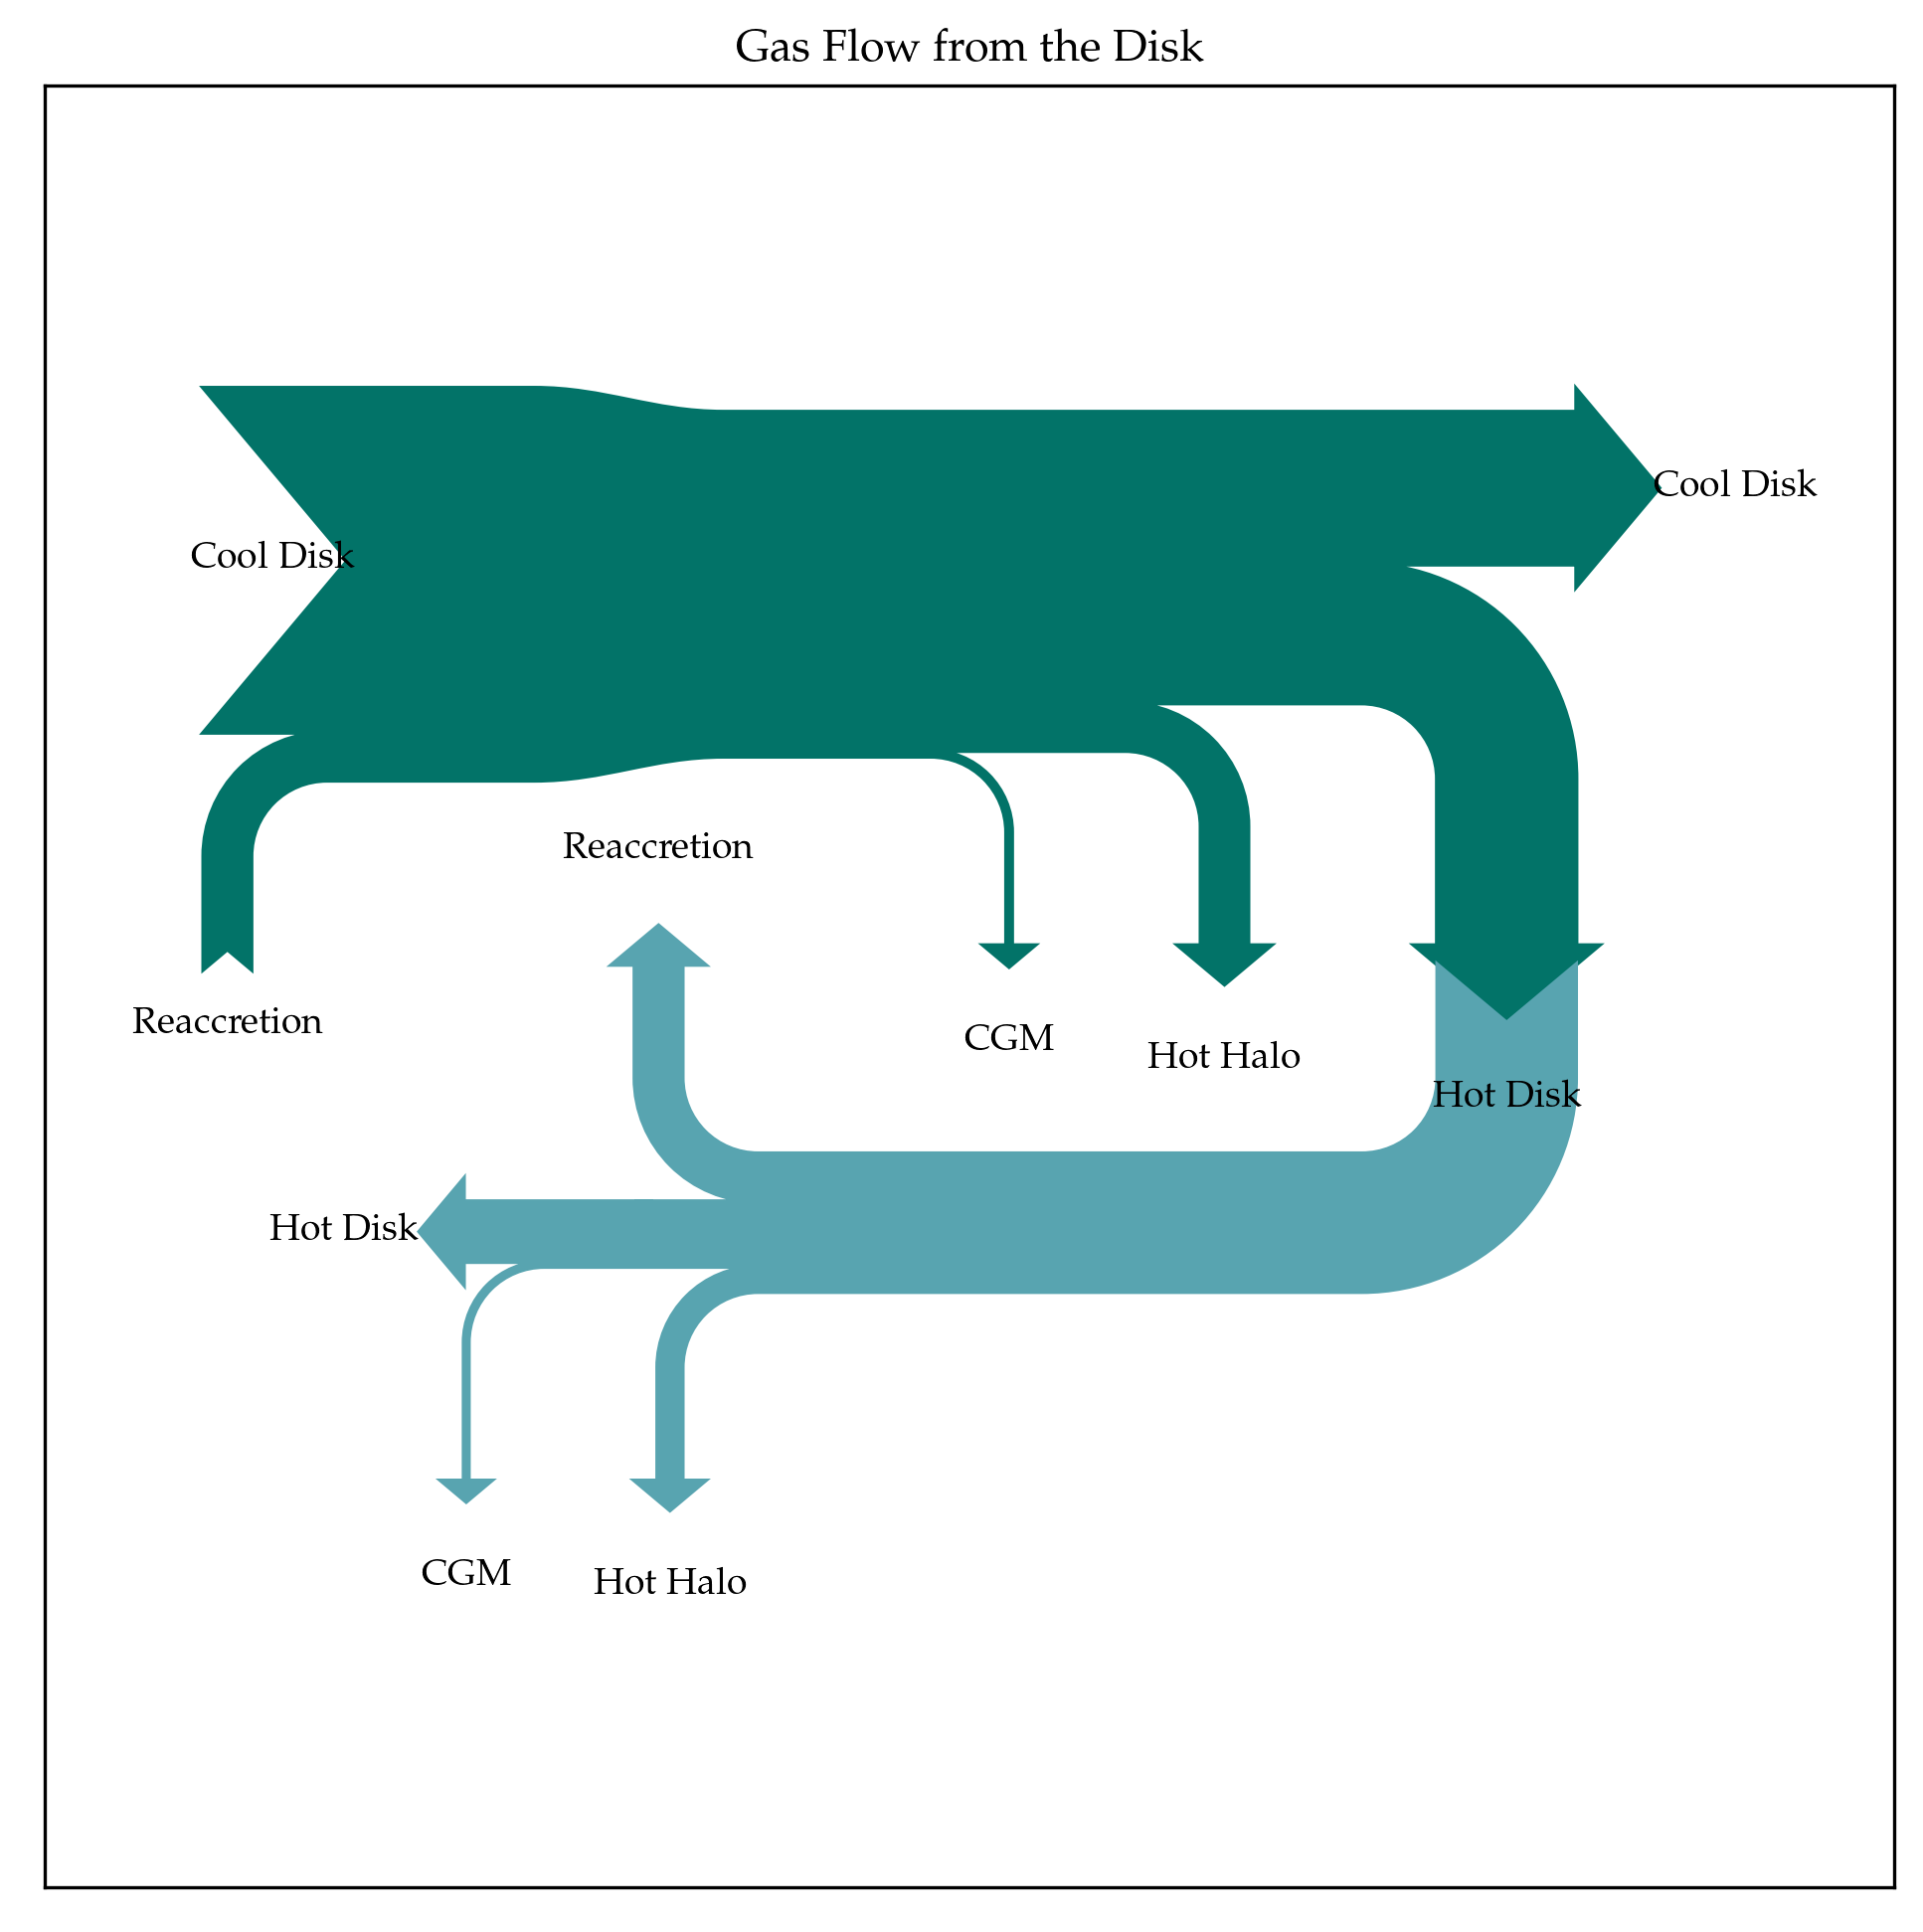

In [197]:
from matplotlib.sankey import Sankey
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[], title="Gas Flow from the Disk")
# ax.axis('off')

sankey = Sankey(ax=ax, 
                scale=0.000000001, 
                offset= 0.1,
                unit = None,
                format = 'none', #'%.2e', 
                tolerance = 1e7)

sankey.add(flows = flows1, 
           labels = labels1, 
           orientations = orientations1,
           edgecolor = '#027368',
           facecolor = '#027368')


sankey.add(flows = flows2,
           labels = labels2,
           orientations = orientations2, 
           prior = 0, # which sankey are you connecting to (0-indexed)
           connect=(3, 0), #flow number to connect: (prior, this)
           edgecolor = '#58A4B0',
           facecolor = '#58A4B0')

sankey.finish()

In [11]:
rates1.columns = ['source','target','value']
rates1

,source,target,value
0,Cool Disk,CGM,7.583869e+06
1,Cool Disk,Cool Disk,2.015059e+08
2,Cool Disk,Hot Disk,1.845660e+08
3,Cool Disk,Hot Halo,6.303500e+07


In [19]:
from floweaver import *
from ipysankeywidget import SankeyWidget

nodes = {
    'source': ProcessGroup(['Cool Disk']),
    'target': ProcessGroup(rates1.target.tolist()),
}

ordering = [
    ['source'], 
    ['waypoint'],
    ['target'],
]

bundles = [
    Bundle('source','target'),
]

nodes['source'].partition = Partition.Simple('source', rates1['source'].unique())
nodes['target'].partition = Partition.Simple('target', rates1['target'].unique())
nodes['waypoint'] = Waypoint()

sdd = SankeyDefinition(nodes, bundles, ordering)
weave(sdd, rates1).to_widget()

SankeyWidget(groups=[{'id': 'source', 'type': 'process', 'title': '', 'nodes': ['source^Cool Disk']}, {'id': '…

In [21]:
from io import StringIO

flows = pd.read_csv(StringIO("""
source,target,type,value
a,b,main,3
b,c,main,4
imports,b,import/export,2
b,exports,import/export,1
"""))

nodes = {
    'a': ProcessGroup(['a']),
    'b': ProcessGroup(['b']),
    'c': ProcessGroup(['c']),
    'imports': Waypoint(),
    'exports': Waypoint(),
}

bundles = [
    Bundle('a', 'b'),
    Bundle('b', 'c'),
    Bundle(Elsewhere, 'b', waypoints=['imports']),
    Bundle('b', Elsewhere, waypoints=['exports']),
]

ordering = [
    [['a'], ['imports']],
    [['b']],
    [['c'], ['exports']],
]

sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows).to_widget()

SankeyWidget(layout=Layout(height='500', width='700'), links=[{'source': 'a^*', 'target': 'b^*', 'type': '*', …

In [1]:

from ipysankeywidget import SankeyWidget
links = [
    {'source': 'start', 'target': 'A', 'value': 2},
    {'source': 'A', 'target': 'B', 'value': 2},
    {'source': 'C', 'target': 'A', 'value': 2},
    {'source': 'A', 'target': 'C', 'value': 2},
]

w = SankeyWidget(links=links, margins=dict(top=0, bottom=0, left=50, right=100))

w



SankeyWidget(links=[{'source': 'start', 'target': 'A', 'value': 2}, {'source': 'A', 'target': 'B', 'value': 2}…

# All transfers, one timestep

In [22]:
thermo_disk = (np.array(data.temp) < 1.2e4) & (np.array(data.rho) > 0.1)
spatial_disk = np.array(data.r_per_Rvir) < 0.15 # eventually the "spatial disk" should be defined as more of the "dynamical disk"
in_satellite = np.array(data.r_per_Rvir) < 1

cool_disk = thermo_disk & spatial_disk
hot_disk = ~thermo_disk & spatial_disk
cool_halo = thermo_disk & ~spatial_disk & in_satellite
hot_halo = ~thermo_disk & ~spatial_disk & in_satellite
CGM = ~in_satellite

In [23]:
c = cool_disk + 2*hot_disk + 3*cool_halo + 4*hot_halo + 5*CGM

In [24]:
classification = []

for i in range(len(c)):
    if c[i] == 1:
        classification.append('Cool Disk')
    elif c[i] == 2:
        classification.append('Hot Disk')
    elif c[i] == 3:
        classification.append('Cool Halo')
    elif c[i] == 4:
        classification.append('Hot Halo')
    elif c[i] == 5:
        classification.append('CGM')
        
classification = np.array(classification,dtype=str)
data['classification'] = classification

In [25]:
# loop through every particle
import tqdm
pids = np.unique(data.pid)
transfers1 = pd.DataFrame(columns = ['t1','t2','event','state1','state2','mass'])

for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    times = np.array(dat.time)
    mass = np.array(dat.mass)
    classification = np.array(dat.classification)
    
    for i,t2 in enumerate(times[1:]):
        i += 1
        t1 = times[i-1]
        c1 = classification[i-1]
        c2 = classification[i]
        
        if (c1 == 'CGM') and (c2 == 'CGM'):
            continue
            
        outdict = {'pid': [pid], 't1':[t1], 't2':[t2], 'state1':[c1], 'state2':[c2], 'mass':[mass[i]]}
        transfers1 = pd.concat([transfers1, pd.DataFrame(outdict)])

100%|██████████| 14729/14729 [15:23<00:00, 15.96it/s]


In [28]:
transfers1.head()

,t1,t2,event,state1,state2,mass,pid
0,8.608831,9.060013,NaN,CGM,Hot Disk,27935.207453,2202002.0
0,9.060013,9.490994,NaN,Hot Disk,Hot Halo,27935.209180,2202002.0
0,9.490994,9.921974,NaN,Hot Halo,Hot Disk,27935.212634,2202002.0
0,9.921974,10.352954,NaN,Hot Disk,Hot Disk,27935.224723,2202002.0
0,10.352954,10.767100,NaN,Hot Disk,Hot Disk,27997.441975,2202002.0


Now we need to compute transfer *rates* from this dataframe. We do this using the handy `groupby` function in `pandas`, which will group the particle dataset by common times and transfer states and sum the mass transfer rate for that transfer at that time.

In [29]:
rates1 = transfers1.groupby(['state1','state2'])['mass'].sum()
rates1 = pd.DataFrame(rates1).reset_index()
rates1

,state1,state2,mass
0,CGM,Hot Disk,1.196850e+06
1,CGM,Hot Halo,6.704607e+07
2,Cool Disk,CGM,7.583869e+06
3,Cool Disk,Cool Disk,2.015059e+08
4,Cool Disk,Hot Disk,1.845660e+08
5,Cool Disk,Hot Halo,6.303500e+07
6,Hot Disk,CGM,1.302612e+07
7,Hot Disk,Cool Disk,1.784901e+08
8,Hot Disk,Hot Disk,2.608415e+08
9,Hot Disk,Hot Halo,9.980806e+07


In [30]:
rates1.columns = ['source','target','value']
rates1

,source,target,value
0,CGM,Hot Disk,1.196850e+06
1,CGM,Hot Halo,6.704607e+07
2,Cool Disk,CGM,7.583869e+06
3,Cool Disk,Cool Disk,2.015059e+08
4,Cool Disk,Hot Disk,1.845660e+08
5,Cool Disk,Hot Halo,6.303500e+07
6,Hot Disk,CGM,1.302612e+07
7,Hot Disk,Cool Disk,1.784901e+08
8,Hot Disk,Hot Disk,2.608415e+08
9,Hot Disk,Hot Halo,9.980806e+07


In [37]:
rates2 = rates1[rates1.source != rates1.target]
rates2

,source,target,value
0,CGM,Hot Disk,1.196850e+06
1,CGM,Hot Halo,6.704607e+07
2,Cool Disk,CGM,7.583869e+06
4,Cool Disk,Hot Disk,1.845660e+08
5,Cool Disk,Hot Halo,6.303500e+07
6,Hot Disk,CGM,1.302612e+07
7,Hot Disk,Cool Disk,1.784901e+08
9,Hot Disk,Hot Halo,9.980806e+07
10,Hot Halo,CGM,3.568351e+08
11,Hot Halo,Cool Disk,2.312191e+07


In [47]:
rates1['type'] = np.where(np.array(rates1.source,dtype=str) == np.array(rates1.target,dtype=str), 'same', 'different')

In [55]:

from floweaver import *
from ipysankeywidget import SankeyWidget

nodes = {
    'source': ProcessGroup(rates1.source.tolist()),
    'target': ProcessGroup(rates1.target.tolist()),
}

ordering = [
    ['source'], 
    ['target'],
]

bundles = [
    Bundle('source','target'),
]

partition = ['Cool Disk', 'Hot Disk', 'Hot Halo', 'CGM']
nodes['source'].partition = Partition.Simple('source', partition)
nodes['target'].partition = Partition.Simple('target', partition)

Type = Partition.Simple('source', partition)

sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition = Type)
weave(sdd, rates1).to_widget()

SankeyWidget(groups=[{'id': 'source', 'type': 'process', 'title': '', 'nodes': ['source^Cool Disk', 'source^Ho…

In [69]:

from floweaver import *
from ipysankeywidget import SankeyWidget

nodes = {
    'source': ProcessGroup(rates2.source.tolist()),
    'target': ProcessGroup(rates2.target.tolist()),
}

ordering = [
    ['source'], 
    ['target'],
]

bundles = [
    Bundle('source','target'),
]

partition = ['Cool Disk', 'Hot Disk', 'Hot Halo', 'CGM']
nodes['source'].partition = Partition.Simple('source', partition)
nodes['target'].partition = Partition.Simple('target', partition)

palette = {'Cool Disk': '#c2d7e8',
           'Hot Disk': 'wheat',
           'Hot Halo': '#fbc3be',
           'CGM':'#e4d5e9'}

sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition = Partition.Simple('source', partition))
weave(sdd, rates2, palette=palette).to_widget()

SankeyWidget(groups=[{'id': 'source', 'type': 'process', 'title': '', 'nodes': ['source^Cool Disk', 'source^Ho…

Another way to visualize this same thing would be to do a pairs plot of starting state on the x-axis and ending state on the y-axis, and color the grid with the mass transfered

In [71]:
data.head().T

,0,1,2,3,4
time,6.47413,6.47413,6.47413,6.47413,6.47413
pid,2202002,2205223,2857672,4057198,4073949
rho,5.03803e-05,3.44515e-05,7.41966e-05,2.30074e-05,2.3801e-05
temp,619654,246612,708055,405099,405992
mass,27934.8,26567.1,26511.6,26510.5,26510.5
coolontime,1.5024,0,0,0,0
r,315.43,345.77,373.135,593.153,588.527
r_per_Rvir,7.44639,8.16263,8.80863,14.0026,13.8934
x,301.379,283.107,360.628,563.303,556.332
y,38.6957,38.728,-35.2823,-183.728,-188.299


# Circular Sankey

In [2]:
from bulk import read_tracked_particles

data = read_tracked_particles('h148',13)

In [3]:
data.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,M,K,U,ratio,cool_disk,hot_disk,cool_halo,hot_halo,CGM,c
0,6.474131,2202002,0.000050,619653.812500,27934.820603,1.502397,315.430011,7.446391,301.379304,38.695749,...,4.158179e+08,5.788096e+44,3.150833e+41,1837.004820,False,False,False,False,True,5
1,6.474131,2205223,0.000034,246611.796875,26567.141174,0.000000,345.770111,8.162633,283.107089,38.728024,...,4.158179e+08,1.108031e+45,2.733631e+41,4053.329018,False,False,False,False,True,5
2,6.474131,2857672,0.000074,708055.187500,26511.576364,0.000000,373.134629,8.808630,360.627617,-35.282347,...,4.158179e+08,1.063645e+45,2.527857e+41,4207.694013,False,False,False,False,True,5
3,6.474131,4057198,0.000023,405099.468750,26510.536704,0.000000,593.153339,14.002636,563.303480,-183.727503,...,4.158179e+08,5.076792e+44,1.590135e+41,3192.679055,False,False,False,False,True,5
4,6.474131,4073949,0.000024,405991.656250,26510.536704,0.000000,588.527236,13.893427,556.331718,-188.298945,...,4.158179e+08,6.286526e+44,1.602634e+41,3922.619861,False,False,False,False,True,5


In [4]:
c = np.array(data.c)
classification = []

for i in range(len(c)):
    if c[i] == 1:
        classification.append('Cool Disk')
    elif c[i] == 2:
        classification.append('Hot Disk')
    elif c[i] == 3:
        classification.append('Cool Halo')
    elif c[i] == 4:
        classification.append('Hot Halo')
    elif c[i] == 5:
        classification.append('CGM')
        
classification = np.array(classification,dtype=str)
data['classification'] = classification

In [6]:
# loop through every particle
import tqdm
pids = np.unique(data.pid)
transfers1 = pd.DataFrame(columns = ['t1','t2','event','state1','state2','mass'])

for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]
    times = np.array(dat.time)
    mass = np.array(dat.mass)
    classification = np.array(dat.classification)
    
    for i,t2 in enumerate(times[1:]):
        i += 1
        t1 = times[i-1]
        c1 = classification[i-1]
        c2 = classification[i]
        
        if (c1 == 'CGM') and (c2 == 'CGM'):
            continue
        elif c1 == c2:
            continue
            
        outdict = {'pid': [pid], 't1':[t1], 't2':[t2], 'state1':[c1], 'state2':[c2], 'mass':[mass[i]]}
        transfers1 = pd.concat([transfers1, pd.DataFrame(outdict)])

100%|██████████| 14729/14729 [04:41<00:00, 52.42it/s]


In [8]:
transfers1.head()

,t1,t2,event,state1,state2,mass,pid
0,8.608831,9.060013,NaN,CGM,Hot Halo,27935.207453,2202002.0
0,10.352954,10.767100,NaN,Hot Halo,Hot Disk,27997.441975,2202002.0
0,10.767100,10.783935,NaN,Hot Disk,Cool Disk,28038.187315,2202002.0
0,10.783935,11.214915,NaN,Cool Disk,Hot Halo,28366.376150,2202002.0
0,11.645896,12.076876,NaN,Hot Halo,Cool Disk,28840.956689,2202002.0


Now we need to compute transfer *rates* from this dataframe. We do this using the handy `groupby` function in `pandas`, which will group the particle dataset by common times and transfer states and sum the mass transfer rate for that transfer at that time.

In [9]:
rates1 = transfers1.groupby(['state1','state2'])['mass'].sum()
rates1 = pd.DataFrame(rates1).reset_index()
rates1

,state1,state2,mass
0,CGM,Hot Disk,2.864116e+06
1,CGM,Hot Halo,6.537881e+07
2,Cool Disk,CGM,7.473788e+06
3,Cool Disk,Cool Halo,5.364108e+06
4,Cool Disk,Hot Disk,9.168755e+07
5,Cool Disk,Hot Halo,1.471761e+08
6,Cool Halo,CGM,1.100814e+05
7,Cool Halo,Cool Disk,6.959369e+06
8,Cool Halo,Hot Disk,2.632886e+06
9,Cool Halo,Hot Halo,6.104533e+06


In [15]:
rates = rates1

In [132]:
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
def drawCirc(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    #========Line
    arc = Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,capstyle='round',linestyle='-',lw=1,color=color_)
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        RegularPolygon(
            (endX, endY),            # (x,y)
            3,                       # number of vertices
            radius/9,                # radius
            rad(angle_+theta2_),     # orientation
            color=color_
        )
    )
    ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 
    # Make sure you keep the axes scaled or else arrow will distort


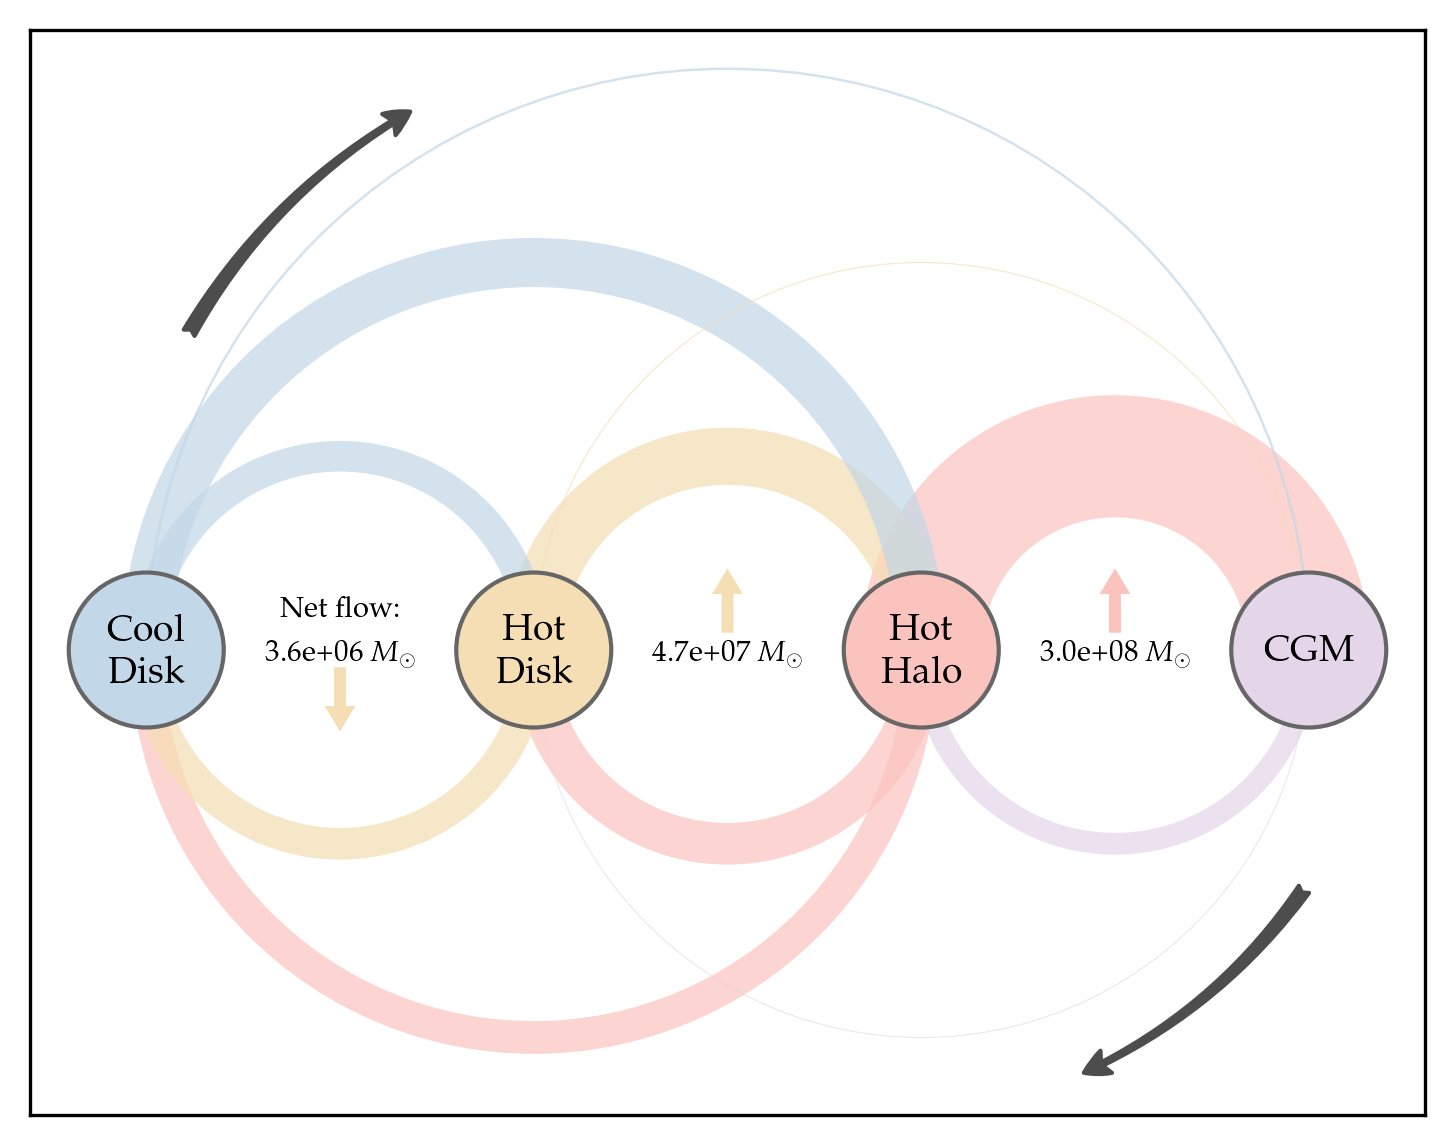

In [195]:
palette = {1: '#c2d7e8',
           2: 'wheat',
           3: '#fbc3be',
           4:'#e4d5e9'}


fig, ax = plt.subplots(1,1,dpi=300, figsize=(6,5))

c1 = mpl.patches.Circle((-15,0), 2, fc=palette[1], ec='0.4', lw=1, zorder=1000)
ax.add_artist(c1)

c2 = mpl.patches.Circle((-5,0), 2, fc=palette[2], ec='0.4', lw=1, zorder=1000)
ax.add_artist(c2)

c3 = mpl.patches.Circle((5,0), 2, fc=palette[3], ec='0.4', lw=1, zorder=1000)
ax.add_artist(c3)

c4 = mpl.patches.Circle((15,0), 2, fc=palette[4], ec='0.4', lw=1, zorder=1000)
ax.add_artist(c4)


scale = 8e-8
# arcs that go from low c to high c go above the x-axis

alpha = 0.7
# arc from c1 to c2, i.e. from cool disk to hot disk
value = rates[(rates.state1=='Cool Disk')&(rates.state2=='Hot Disk')].mass.tolist()[0]
c1_c2 = mpl.patches.Arc((-10, 0), 10, 10, linewidth = value*scale, theta1=0, theta2=180, color=palette[1], zorder=-value, alpha=alpha)
ax.add_artist(c1_c2)

# arc from c1 to c3, i.e. from cool disk to hot halo
value = rates[(rates.state1=='Cool Disk')&(rates.state2=='Hot Halo')].mass.tolist()[0]
c1_c3 = mpl.patches.Arc((-5, 0), 20, 20, linewidth = value*scale, theta1=0, theta2=180, color=palette[1], zorder=-value, alpha=alpha)
ax.add_artist(c1_c3)

# arc from c1 to c4, i.e. from cool disk to CGM
value = rates[(rates.state1=='Cool Disk')&(rates.state2=='CGM')].mass.tolist()[0]
c1_c4 = mpl.patches.Arc((0, 0), 30, 30, linewidth = value*scale, theta1=0, theta2=180, color=palette[1], zorder=-value, alpha=alpha)
ax.add_artist(c1_c4)


# arc from c2 to c3, i.e. from hot disk to hot halo
value = rates[(rates.state1=='Hot Disk')&(rates.state2=='Hot Halo')].mass.tolist()[0]
c2_c3 = mpl.patches.Arc((0, 0), 10, 10, linewidth = value*scale, theta1=0, theta2=180, color=palette[2], zorder=-value, alpha=alpha)
ax.add_artist(c2_c3)

# arc from c2 to c4, i.e. from hot disk to CGM
value = rates[(rates.state1=='Hot Disk')&(rates.state2=='CGM')].mass.tolist()[0]
c2_c4 = mpl.patches.Arc((5, 0), 20, 20, linewidth = value*scale, theta1=0, theta2=180, color=palette[2], zorder=-value, alpha=alpha)
ax.add_artist(c2_c4)

# arc from c3 to c4, i.e. from hot Halo to CGM
value = rates[(rates.state1=='Hot Halo')&(rates.state2=='CGM')].mass.tolist()[0]
c3_c4 = mpl.patches.Arc((10, 0), 10, 10, linewidth = value*scale, theta1=0, theta2=180, color=palette[3], zorder=-value, alpha=alpha)
ax.add_artist(c3_c4)



# arcs that go from high c to low c go below the x-axis


# arc from c2 to c1, i.e. from hot disk to cool disk
value = rates[(rates.state1=='Hot Disk')&(rates.state2=='Cool Disk')].mass.tolist()[0]
c2_c1 = mpl.patches.Arc((-10, 0), 10, 10, linewidth = value*scale, theta1=180, theta2=0, color=palette[2], zorder=-value, alpha=alpha)
ax.add_artist(c2_c1)

# arc from c3 to c2, i.e. from hot halo to hot disk
value = rates[(rates.state1=='Hot Halo')&(rates.state2=='Hot Disk')].mass.tolist()[0]
c3_c2 = mpl.patches.Arc((0, 0), 10, 10, linewidth = value*scale, theta1=180, theta2=0, color=palette[3], zorder=-value, alpha=alpha)
ax.add_artist(c3_c2)

# arc from c3 to c1, i.e. from hot halo to cool disk
value = rates[(rates.state1=='Hot Halo')&(rates.state2=='Cool Disk')].mass.tolist()[0]
c3_c1 = mpl.patches.Arc((-5, 0), 20, 20, linewidth = value*scale, theta1=180, theta2=0, color=palette[3], zorder=-value, alpha=alpha)
ax.add_artist(c3_c1)


# arc from c4 to c1, i.e. from CGM to cool disk
# doesn't ever happen

# arc from c4 to c2, i.e. from CGM to hot disk
value = rates[(rates.state1=='CGM')&(rates.state2=='Hot Disk')].mass.tolist()[0]
c4_c2 = mpl.patches.Arc((5, 0), 20, 20, linewidth = value*scale, theta1=180, theta2=0, color=palette[4], zorder=-value, alpha=alpha)
ax.add_artist(c4_c2)

# arc from c4 to c2, i.e. from CGM to hot halo
value = rates[(rates.state1=='CGM')&(rates.state2=='Hot Halo')].mass.tolist()[0]
c4_c3 = mpl.patches.Arc((10, 0), 10, 10, linewidth = value*scale, theta1=180, theta2=0, color=palette[4], zorder=-value, alpha=alpha)
ax.add_artist(c4_c3)


ax.set_xlim(-18,18)
ax.set_ylim(-12,16)

ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax.annotate('Cool \n Disk', (-15, -0.1), zorder=1001, va='center', ha='center')
ax.annotate('Hot \n Disk', (-5, -0.1), zorder=1001, va='center', ha='center')
ax.annotate('Hot \n Halo', (5, -0.1), zorder=1001, va='center', ha='center')
ax.annotate('CGM', (15, -0.1), zorder=1001, va='center', ha='center')

ax.set_aspect('equal')
# ax.axis('off')

style = "fancy, tail_width=0.2"
kw = dict(arrowstyle=style, color="0.3", mutation_scale=15)

a1 = mpl.patches.FancyArrowPatch((-14, 8), (-8, 14), connectionstyle="arc3,rad=-0.14", **kw)
ax.add_artist(a1)

a2 = mpl.patches.FancyArrowPatch((15, -6), (9, -11), connectionstyle="arc3,rad=-0.14", **kw)
ax.add_artist(a2)



up = rates[(rates.state1=='Cool Disk')&(rates.state2=='Hot Disk')].mass.tolist()[0]
down = rates[(rates.state1=='Hot Disk')&(rates.state2=='Cool Disk')].mass.tolist()[0]
y = 0.5
dy = 1
if up > down:
    color = palette[1]
elif up < down:
    y *= -1
    dy *= -1
    color = palette[2]
    
ax.annotate(f'{np.abs(up-down):.1e}~$M_\odot$',(-10, -0.15), ha='center', va='center', size=7)
ax.arrow(-10, y, 0, dy, color=color, width=0.2, head_length=0.5)


up = rates[(rates.state1=='Hot Disk')&(rates.state2=='Hot Halo')].mass.tolist()[0]
down = rates[(rates.state1=='Hot Halo')&(rates.state2=='Hot Disk')].mass.tolist()[0]
y = 0.5
dy = 1
if up > down:
    color = palette[2]
elif up < down:
    y *= -1
    dy *= -1
    color = palette[3]
    
ax.annotate(f'{np.abs(up-down):.1e}~$M_\odot$',(0, -0.15), ha='center', va='center', size=7)
ax.arrow(0, y, 0, dy, color=color, width=0.2, head_length=0.5)



up = rates[(rates.state1=='Hot Halo')&(rates.state2=='CGM')].mass.tolist()[0]
down = rates[(rates.state1=='CGM')&(rates.state2=='Hot Halo')].mass.tolist()[0]
y = 0.5
dy = 1
if up > down:
    color = palette[3]
elif up < down:
    y *= -1
    dy *= -1
    color = palette[4]
    
ax.annotate(f'{np.abs(up-down):.1e}~$M_\odot$',(10, -0.15), ha='center', va='center', size=7)
ax.arrow(10, y, 0, dy, color=color, width=0.2, head_length=0.5)

ax.annotate('Net flow:', (-10, 1), va='center', ha='center', size=7)


plt.show()